### Compare cerebellar volumes across datasets

#### Datasets
- NIMHANS
- QPN


In [1]:
import sys
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting
from pathlib import Path

In [13]:
dataset = "qpn"
current_release = "Jan_2024"
maget_verion = "1.0.0"
session = "ses-01"

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
tabular_dir = f"{dataset_dir}/releases/{current_release}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{tabular_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# imaging derivatives
maget_dir = f"{dataset_dir}/derivatives/maget_brain/v{maget_verion}/"
CB_vol_csv = f"{maget_dir}/output/ses-01/cerebellum_segmentations/cerebellar_volumes.csv"

# save dirs
results_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/agg_dfs/"
figs_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/figs/"

# Create dirs for results if they don't exist
Path(f"{results_dir}").mkdir(parents=True, exist_ok=True)
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

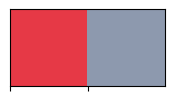

In [14]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

In [11]:
def quick_QC(df, check_cols, min_val, max_val, index_col="participant_id"):
    """Checks for NaNs and out of range outliers """
    
    if index_col in df.columns:
        # check NaNs
        nan_participants = df[df[check_cols].isna().any(axis=1)][index_col].values
        n_nans = len(nan_participants)

        # check range
        outlier_participants = df[df[check_cols].apply(lambda x: (x < min_val) | (x > max_val)).any(axis=1)][index_col].values
        n_outliers = len(outlier_participants)

        print(f"found {n_nans} NaNs and {n_outliers} outliers")
        return list(nan_participants), list(outlier_participants)
    
    else:
        print(f"Provide an index column")
        return None, None

def merge_CB_demo_df(CB_df, demo_df, cerebellar_lobules):
    left_lobules = list("L_" + pd.Series(cerebellar_lobules))
    right_lobules = list("R_" + pd.Series(cerebellar_lobules))
    lh_lobule_dict = dict(zip(left_lobules,cerebellar_lobules))
    rh_lobule_dict = dict(zip(right_lobules,cerebellar_lobules))

    CB_df["bids_id"] = CB_df["Subject"].str.rsplit("/", n=1, expand=True)[1].str.split("_", expand=True)[0]
    CB_df["participant_id"] = CB_df["bids_id"].str.split("-", expand=True)[1]

    # merge with demo
    CB_demo_df = pd.merge(CB_df, demo_df, on="participant_id", how="inner")
    CB_demo_df = CB_demo_df.drop(columns=["Subject"])

    demo_cols = list(set(CB_demo_df.columns) - set(left_lobules) - set(right_lobules))

    left_CB_df = CB_demo_df[demo_cols + left_lobules].copy()
    left_CB_df["hemi"] = "left"
    right_CB_df = CB_demo_df[demo_cols + right_lobules].copy()
    right_CB_df["hemi"] = "right"

    # add total CB vol column
    left_CB_df["total_CB_vol"] = left_CB_df[left_lobules].sum(axis=1)
    right_CB_df["total_CB_vol"] = right_CB_df[right_lobules].sum(axis=1)

    # rename columns to stack vertically
    left_CB_df = left_CB_df.rename(columns=lh_lobule_dict)
    right_CB_df = right_CB_df.rename(columns=rh_lobule_dict)
    
    CB_demo_df = pd.concat([left_CB_df, right_CB_df], axis=0)

    return CB_demo_df

### Demographic data

In [16]:
group_col = "group_at_screening"

# useful groups:
useful_groups = ["PD", "control"]

demographics_df = pd.read_csv(demographics_csv)
demographics_df = demographics_df[demographics_df["visit"] == "MRI_v1"]

participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")

# replace column values
demographics_df[group_col] = demographics_df[group_col].replace({"PD   (Parkinson's Disease)/Maladie de Parkinson":"PD", 
                                                               "Healthy control/Contrôle": "control",
                                                               "PPS (Parkinson Plus Syndrome)/PPS (Syndrome Parkinson Plus)": "PPS"})

group_counts = demographics_df.groupby([group_col])["participant_id"].count()
print(f"group counts: {group_counts}")

# filter out useful groups
demographics_df = demographics_df[demographics_df[group_col].isin(useful_groups)]
demographics_df = demographics_df.rename(columns={group_col:"group"})

demographics_df.head()

n_participants: 286
group counts: group_at_screening
PD         203
PPS         11
control     67
Name: participant_id, dtype: int64


,participant_id,redcap_event_name,group,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0028,Baseline (Arm 1: C-OPN),PD,M,18,3.5,PD,MRI,v1,60.19,MRI_v1
5,MNI0056,Baseline (Arm 1: C-OPN),PD,M,6,6.5,NaN,MRI,v1,79.24,MRI_v1
9,MNI0058,Baseline (Arm 1: C-OPN),PD,M,11,3.8,PD,MRI,v1,57.43,MRI_v1
13,MNI0068,Baseline (Arm 1: C-OPN),PD,M,12,10.2,PD,MRI,v1,69.30,MRI_v1
16,MNI0079,Baseline (Arm 1: C-OPN),PD,F,20+,6.8,PD,MRI,v1,50.08,MRI_v1


### Get merged cerebellar volumes + demo df

In [34]:
cerebellar_lobules = ['I_II', 'III', 'IV', 'V', 'VI', 'Crus_I', 'Crus_II','VIIB', 'VIIIA', 'VIIIB', 'IX', 'X', 'CM']
demo_cols = ["participant_id", "group","visit"]
demographics_df = demographics_df[demo_cols].copy()

CB_vols_df = pd.read_csv(f"{CB_vol_csv}")
n_CB_participants = CB_vols_df["Subject"].nunique()
print(f"n_CB_participants: {n_CB_participants}")

CB_demo_vols_df = merge_CB_demo_df(CB_vols_df, demographics_df, cerebellar_lobules)
CB_demo_vols_df.head()

n_CB_participants: 284


,visit,participant_id,group,bids_id,I_II,III,IV,V,VI,Crus_I,Crus_II,VIIB,VIIIA,VIIIB,IX,X,CM,hemi,total_CB_vol
0,MRI_v1,MNI0028,PD,sub-MNI0028,94.0,1199,2763.0,4972.0,7667.0,11026,10088.0,4624.0,5285.0,2898.0,2979.0,565.0,9676.0,left,63836.0
1,MRI_v1,MNI0058,PD,sub-MNI0058,110.0,943,2350.0,3666.0,7841.0,11602,7483.0,3236.0,4688.0,3585.0,3920.0,604.0,8405.0,left,58433.0
2,MRI_v1,MNI0056,PD,sub-MNI0056,89.0,906,1573.0,3147.0,7763.0,11064,7382.0,3258.0,4530.0,3509.0,3737.0,532.0,7978.0,left,55468.0
3,MRI_v1,MNI0068,PD,sub-MNI0068,110.0,845,1630.0,4306.0,7956.0,12000,6991.0,3569.0,5157.0,3463.0,4025.0,402.0,7254.0,left,57708.0
4,MRI_v1,MNI0079,PD,sub-MNI0079,90.0,1006,2687.0,4080.0,6965.0,13163,6894.0,3331.0,5445.0,3568.0,2957.0,559.0,8472.0,left,59217.0


### Remove outliers
 This is structure specific (need to be QCed visually)

In [35]:
min_vol_thresh_list = [25, 400, 900, 2000, 4500, 6000, 4000, 2000, 2000, 1500, 1500, 200, 4000, 32000]
max_vol_thresh_list = [200, 1300, 3500, 6000, 11000, 18000, 13000, 7000, 8000, 5000, 6000, 800, 13000, 80000]
outlier_min_thesh_dict = dict(zip(cerebellar_lobules, min_vol_thresh_list))
outlier_max_thesh_dict = dict(zip(cerebellar_lobules, max_vol_thresh_list))

print("Removing outliers")
for roi, thresh in outlier_min_thesh_dict.items():
    n_participants = CB_demo_vols_df["participant_id"].nunique()
    print(f"roi: {roi}, n_participants: {n_participants}")
    CB_vol_df = CB_demo_vols_df[CB_demo_vols_df[roi] > thresh].copy()
    n_participants = CB_demo_vols_df["participant_id"].nunique()
    print(f"n_participants after outlier removal: {n_participants}")

for roi, thresh in outlier_max_thesh_dict.items():
    n_participants = CB_demo_vols_df["participant_id"].nunique()
    print(f"roi: {roi}, n_participants: {n_participants}")
    CB_vol_df = CB_demo_vols_df[CB_demo_vols_df[roi] < thresh].copy()
    n_participants = CB_demo_vols_df["participant_id"].nunique()
    print(f"n_participants after outlier removal: {n_participants}")


Removing outliers
roi: I_II, n_participants: 258
n_participants after outlier removal: 258
roi: III, n_participants: 258
n_participants after outlier removal: 258
roi: IV, n_participants: 258
n_participants after outlier removal: 258
roi: V, n_participants: 258
n_participants after outlier removal: 258
roi: VI, n_participants: 258
n_participants after outlier removal: 258
roi: Crus_I, n_participants: 258
n_participants after outlier removal: 258
roi: Crus_II, n_participants: 258
n_participants after outlier removal: 258
roi: VIIB, n_participants: 258
n_participants after outlier removal: 258
roi: VIIIA, n_participants: 258
n_participants after outlier removal: 258
roi: VIIIB, n_participants: 258
n_participants after outlier removal: 258
roi: IX, n_participants: 258
n_participants after outlier removal: 258
roi: X, n_participants: 258
n_participants after outlier removal: 258
roi: CM, n_participants: 258
n_participants after outlier removal: 258
roi: I_II, n_participants: 258
n_particip

### Plots

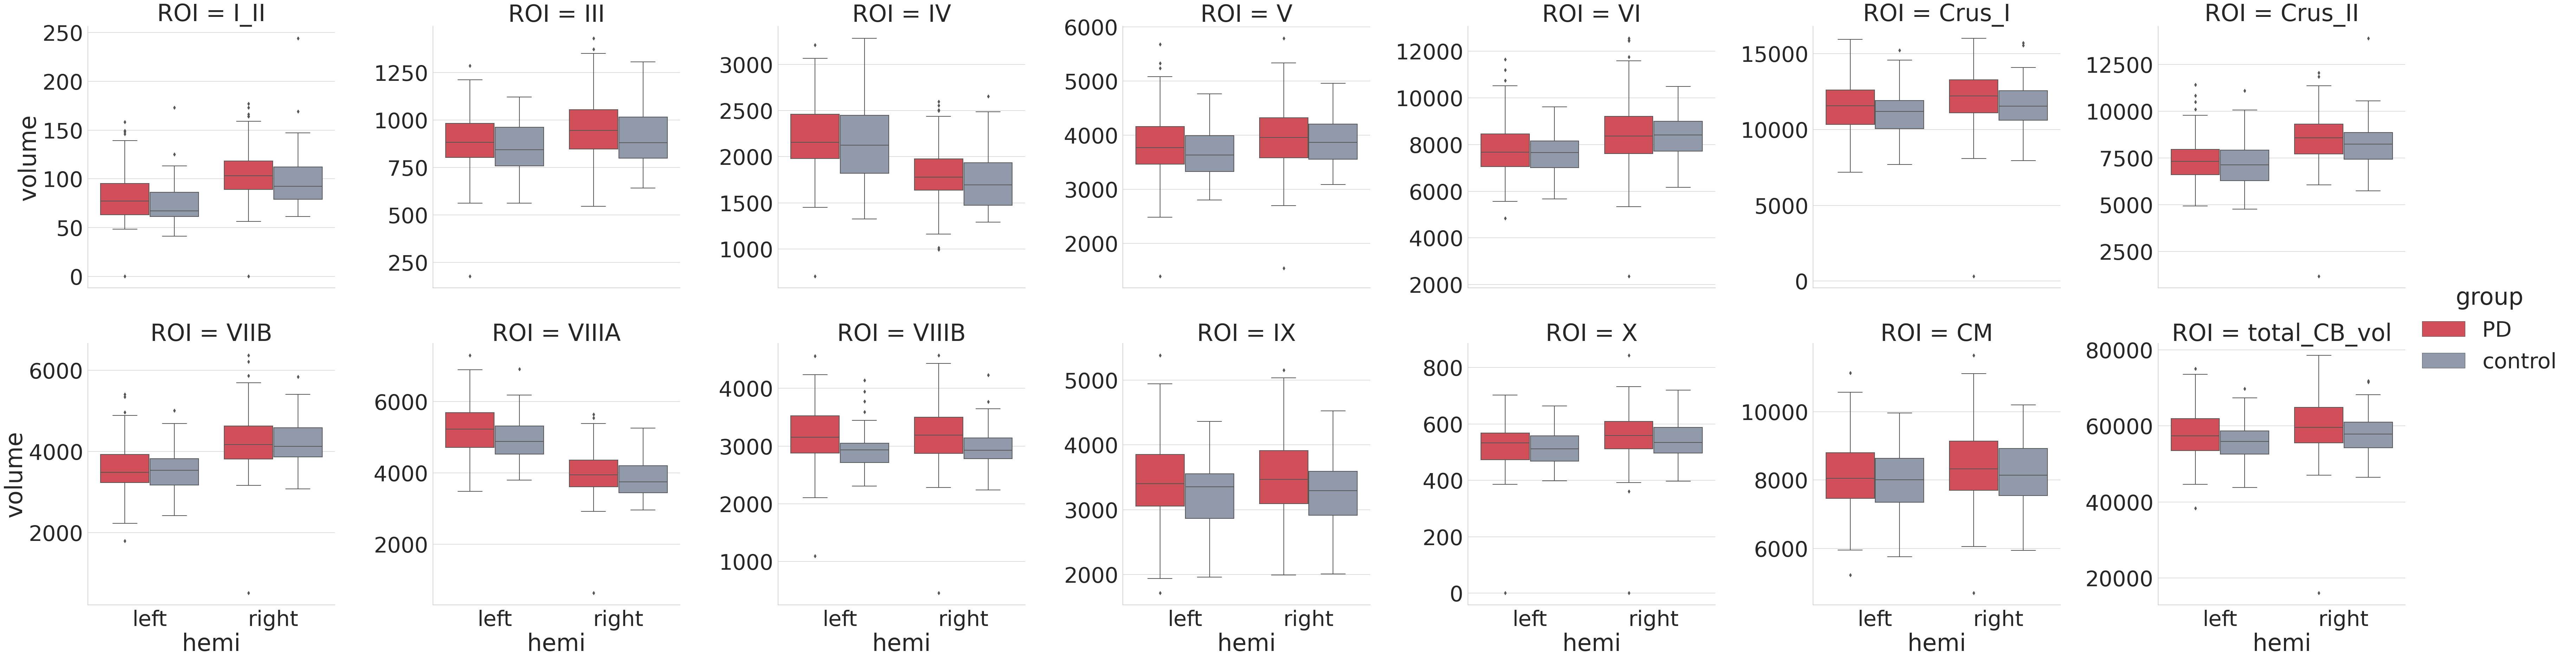

In [36]:
save_fig = False
# CB_demo_vols_df = CB_demo_vols_df.drop(columns=["bids_id"])
CB_vol_df_melt = CB_demo_vols_df.melt(
    id_vars=demo_cols + ["bids_id", "hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = CB_vol_df_melt.copy()

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=7, #col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)
    
if save_fig:
    g.savefig(f"{figs_dir}/CB_vol.png")

In [2]:
import numpy as np



array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])